<a href="https://colab.research.google.com/github/tajski/Projekt-Sieci-Neuronowe/blob/main/Projekt_Sieci_Neuronowe_BT_KW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Bartosz 42885 & Kacper 43467***

---





# **Retinopatia cukrzycowa a sieci neuronowe?**

Retinopatia cukrzycowa (tzw. "cukrzycowa choroba oczu") oznacza patologiczne zmiany w siatkówce. Choroba ta wynika z długotrwałych uszkodzeń naczyń krwionośnych w gałce ocznej i może w poważny sposób zaburzać funkcje wzrokowe u osób chorujących na cukrzycę.
Czy więc dzięki sieciom neuronowym możemy w korzystny sposób wpłynąć na badanie choroby? Otóż badania zilustrowane na naszym zbiorze danych mogą przynieść wiele korzyści:

1. Wczesne wykrywanie i interwencja: Diabetologiczne retinopatie są poważnym zagrożeniem dla wzroku, ale ich wczesne wykrycie i leczenie mogą znacząco zmniejszyć ryzyko utraty wzroku. Narzędzie oparte na sieciach neuronowych może pomóc w szybkim i skutecznym skriningu retinopatii cukrzycowej, co umożliwi szybszą interwencję leczniczą.

2. Redukcja błędów ludzkich: Interpretacja obrazów siatkówki może być czasochłonna i podatna na ludzkie błędy. Automatyczne narzędzie oparte na sieciach neuronowych może zmniejszyć ryzyko błędów ludzkich i zapewnić bardziej jednolite wyniki diagnostyczne.

3. Zwiększenie dostępności opieki zdrowotnej: Wiele regionów cierpi na brak specjalistów okulistycznych, szczególnie w obszarach wiejskich lub z ograniczonymi zasobami. System automatycznej detekcji retinopatii cukrzycowej może pomóc w zwiększeniu dostępności opieki zdrowotnej poprzez umożliwienie szybszej diagnozy i leczenia pacjentów.

4. Optymalizacja zasobów: Zautomatyzowane narzędzie może pomóc w zoptymalizowaniu wykorzystania zasobów ludzkich w opiece zdrowotnej. Zamiast poświęcać czas lekarzy na interpretację obrazów, mogą oni skoncentrować się na bardziej skomplikowanych przypadkach i zapewnieniu spersonalizowanej opieki pacjentom.

5. Badania i rozwój: Badania nad tym zbiorem danych i implementacja systemu opartego na sieciach neuronowych mogą przyczynić się do dalszego zrozumienia retinopatii cukrzycowej i doskonalenia technologii w zakresie obrazowania medycznego. To może prowadzić do kolejnych innowacji i ulepszeń w dziedzinie diagnostyki i leczenia chorób oczu.

W rezultacie, opracowanie i zastosowanie narzędzia opartego na sieciach neuronowych dla tego zbioru danych może przynieść korzyści zarówno dla pacjentów, jak i dla systemów opieki zdrowotnej.


# **Retinopatia cukrzycowa vs sieci neuronowe**

## Import wymaganych bibliotek

In [1]:
import numpy as np
import pandas as pd
import os
from google.colab import drive
from matplotlib import pyplot as plt
from keras.utils import image_dataset_from_directory
from keras import layers, Model
from keras.models import Sequential
from keras.utils import plot_model
from keras.metrics import CategoricalAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, Accuracy, binary_accuracy
from keras.applications import ResNet50
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dropout

## Montaż dysku Google

In [2]:
drive.mount('/content/drive', force_remount=True)
!unzip -q "/content/drive/MyDrive/Colab Notebooks/diabetic.zip"

Mounted at /content/drive


## Przygotowanie zbiorów danych

Nasz zbiór składa się z trzech rodzajów danych: danych treningowych, testowych oraz walidacyjnych. Najwięcej danych jest w folderze treningowym, potem walidacyjnym a na końcu testowym.

Dane te możemy podzielić na dwie klasy: DR oraz No_DR, które kolejno oznaczają występowanie retinopatii cukrzycowej oraz jej brak. Dane są zbalansowane blisko 1:1.

In [3]:
train_data_root = "train"
test_data_root = "test"
valid_data_root = "valid"

train_data = {}
test_data = {}
valid_data = {}

# Przechodzenie przez katalogi treningowe
for root, dirs, files in os.walk(train_data_root):
    for dir in dirs:
        dir_path = os.path.join(root, dir)
        train_data[dir] = os.listdir(dir_path)

print("Dane treningowe:")
for x in train_data:
    print(x, len(train_data[x]))

# Przechodzenie przez katalogi testowe
for root, dirs, files in os.walk(test_data_root):
    for dir in dirs:
        dir_path = os.path.join(root, dir)
        test_data[dir] = os.listdir(dir_path)

print()

print("Dane testowe:")
for x in test_data:
    print(x, len(test_data[x]))

    # Przechodzenie przez katalogi walidacyjne
for root, dirs, files in os.walk(valid_data_root):
    for dir in dirs:
        dir_path = os.path.join(root, dir)
        valid_data[dir] = os.listdir(dir_path)

print()

print("Dane walidacyjne:")
for x in valid_data:
    print(x, len(valid_data[x]))

Dane treningowe:
No_DR 1026
DR 1050

Dane testowe:
No_DR 118
DR 113

Dane walidacyjne:
No_DR 286
DR 245


In [4]:
train_dataset, valid_dataset = image_dataset_from_directory(train_data_root, validation_split=0.2,
                                       subset='both',
                                       seed=1410,
                                       image_size=(256, 256),
                                       label_mode='categorical',
                                      color_mode="rgb"
                                       )

test_dataset = image_dataset_from_directory(test_data_root, seed=1410,
                                       image_size=(256, 256),
                                       label_mode='categorical',
                                      color_mode="rgb"
                                       )

Found 2076 files belonging to 2 classes.
Using 1661 files for training.
Using 415 files for validation.
Found 231 files belonging to 2 classes.


## Wizualizacja danych w katalogy treningowym

['DR', 'No_DR']


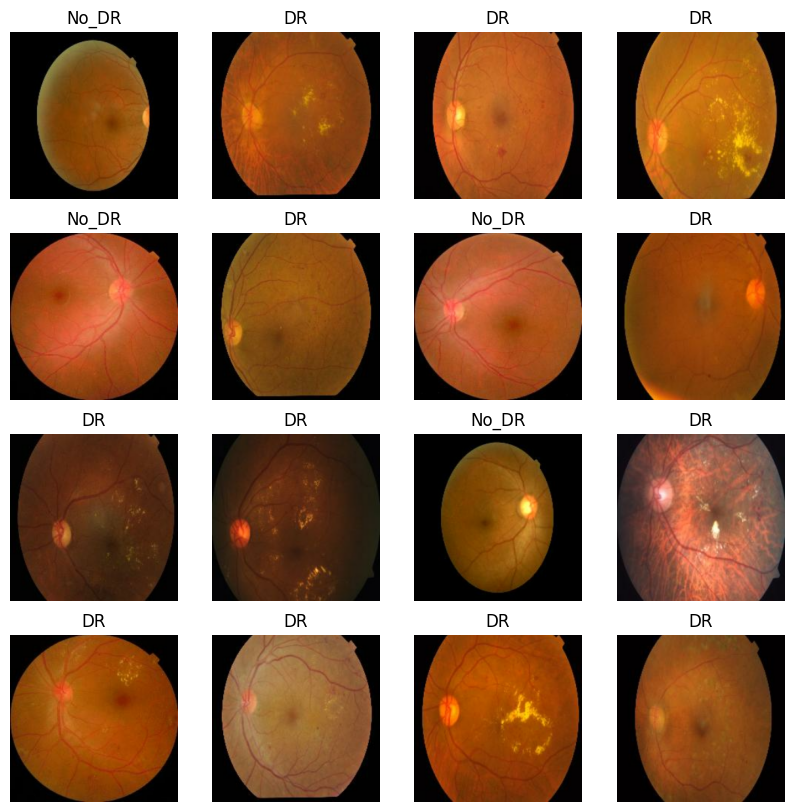

In [5]:
class_names = train_dataset.class_names
print(class_names)

%matplotlib inline
fig, ax = plt.subplots(4,4, figsize=(10,10))


for images, labels in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(np.argmax(labels[i]))])
        plt.axis("off")

# **Sieci Konwulcyjne**

### Model 1

Przygotowanie pierwszego modelu z wykorzystaniem sieci konwulcyjnych. Użyte warstwy:


*   Rescaling jako warstwa wejściowa przyjmująca obrazy o rozmiarze 256x256 i 3 kanałach wejścia
*   Warstwy konwulcyjne rosnące od 16 do 1024 ze stałą wielkością jądra jako wektor 2x2
*   Warstwy normalizacyjne
*   Warstwy łączące
*   Warstwa spłaszczająca
*   Warstwy gęste
*   Warstwa porzucania









In [6]:
modelCNN = Sequential([
  layers.Rescaling(1.0 / 255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, (2,2), strides=2, padding='same', activation="relu"),
  layers.Conv2D(32, (2,2), padding='same', activation="relu"),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Conv2D(64, (2,2), padding='same', activation="relu"),
  layers.MaxPooling2D(2),
  layers.Conv2D(128, (2,2), padding='same', activation="relu"),
  layers.MaxPooling2D(2),
  layers.Conv2D(256, (2,2), padding='same', activation="relu"),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Conv2D(512, (2,2), padding='same', activation="relu"),
  layers.MaxPooling2D(2),
  layers.Conv2D(1024, (2,2), padding='same', activation="relu"),
  layers.MaxPooling2D(2),
  layers.Flatten(),
  layers.Dense(512, activation="relu"),
  layers.Dropout(0.5),
  layers.Dense(2, activation="softmax")
])
plot_model(modelCNN, show_shapes=True)

Kompilacja pierwszego modelu przy użyciu optymatyzatora "adam" oraz metryki categorical_accuracy.

Uczenie sieci odbywa się natomiast na podstawie wsadu o wielkości 32 oraz 40 epokach.


In [7]:
# Kompilacja
modelCNN.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])


# Uczenie sieci
historyCNN = modelCNN.fit(train_dataset, epochs=40, validation_data=valid_dataset,
                    batch_size=32)

Epoch 1/40
52/52 [==============================] - 10s 43ms/step - loss: 0.7955 - accuracy: 0.7983 - val_loss: 0.6912 - val_accuracy: 0.4819
Epoch 2/40
52/52 [==============================] - 1s 20ms/step - loss: 0.2366 - accuracy: 0.9163 - val_loss: 0.7990 - val_accuracy: 0.4916
Epoch 3/40
52/52 [==============================] - 1s 20ms/step - loss: 0.2167 - accuracy: 0.9109 - val_loss: 0.7340 - val_accuracy: 0.4916
Epoch 4/40
52/52 [==============================] - 1s 20ms/step - loss: 0.2028 - accuracy: 0.9266 - val_loss: 0.6210 - val_accuracy: 0.8241
Epoch 5/40
52/52 [==============================] - 1s 19ms/step - loss: 0.2073 - accuracy: 0.9290 - val_loss: 0.9387 - val_accuracy: 0.4916
Epoch 6/40
52/52 [==============================] - 1s 19ms/step - loss: 0.1946 - accuracy: 0.9320 - val_loss: 0.7344 - val_accuracy: 0.4916
Epoch 7/40
52/52 [==============================] - 1s 19ms/step - loss: 0.1738 - accuracy: 0.9386 - val_loss: 0.5340 - val_accuracy: 0.6578
Epoch 8/40
5

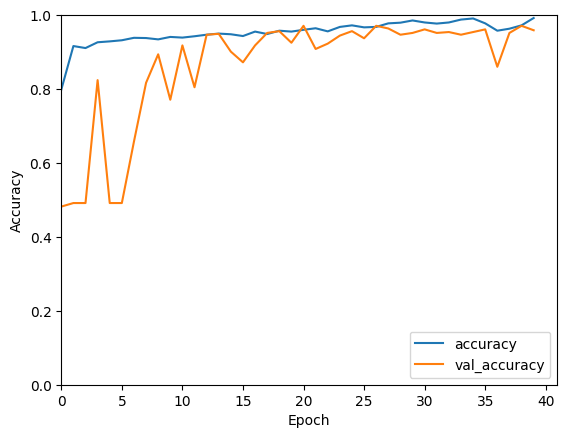

In [8]:
plt.plot(historyCNN.history['accuracy'], label='accuracy')
plt.plot(historyCNN.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.xlim(left=0)
plt.legend(loc='lower right')

In [9]:
resultCNN = modelCNN.evaluate(test_dataset, return_dict=True)

print(f'Dokładność modelu {round(resultCNN["accuracy"]*100,2)}%')

8/8 [==============================] - 0s 34ms/step - loss: 0.4504 - accuracy: 0.9394
Dokładność modelu 93.94%


Dokładność modelu wynosi 93.94%.

Widoczny jest dość późny wzrost dokładności z widocznymi szumami.

### **Model 2**

Budowa modelu drugiego różni się znacząco od poprzedniego, mianowicie:


*   Brak warstwy normalizacyjnej
*   Warstwa konsulcyjna jako warstwa wejściowa o tych samych parametrach wejściowych
*   Mniejsza liczba warstw konwulcyjnych osiągających maksymalnie wartości 128 filtrów. Jądro jako wektor 3x3.
*   Dodanie warstwy gęstej po środku oraz warstwy porzucania



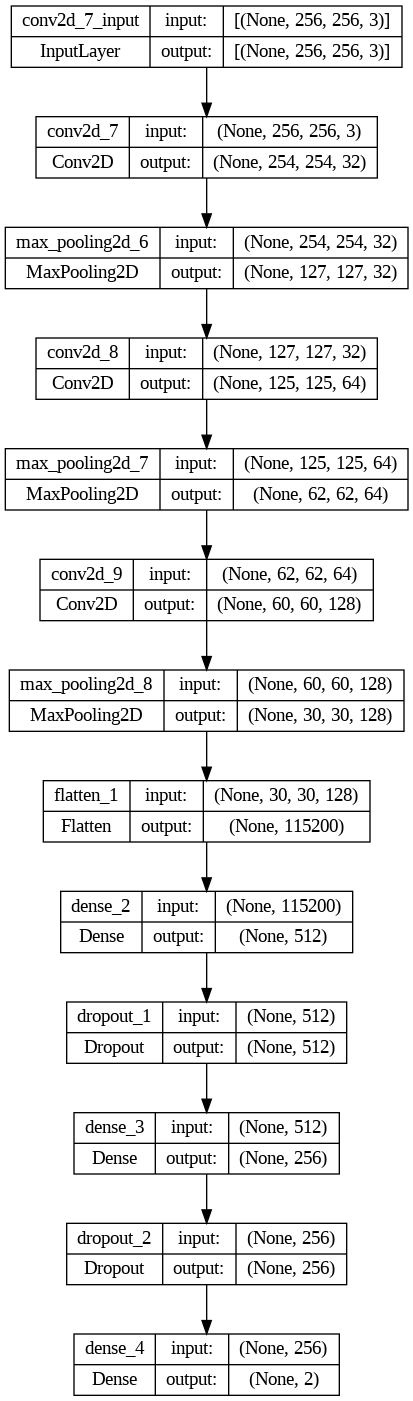

In [10]:
modelCNN_2 = Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(2, activation='softmax')

])
plot_model(modelCNN_2, show_shapes=True)

Liczba epok i wsadu pozostaje niezmienna, tak jak metryka i optymalizator.

In [11]:
# Kompilacja
modelCNN_2.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])


# Uczenie sieci
historyCNN_2 = modelCNN_2.fit(train_dataset, epochs=40, validation_data=valid_dataset,
                    batch_size=32)

Epoch 1/40
52/52 [==============================] - 5s 46ms/step - loss: 31.1116 - accuracy: 0.8019 - val_loss: 0.1975 - val_accuracy: 0.9373
Epoch 2/40
52/52 [==============================] - 1s 23ms/step - loss: 0.2663 - accuracy: 0.9079 - val_loss: 0.1762 - val_accuracy: 0.9349
Epoch 3/40
52/52 [==============================] - 1s 23ms/step - loss: 0.2371 - accuracy: 0.9127 - val_loss: 0.1762 - val_accuracy: 0.9398
Epoch 4/40
52/52 [==============================] - 1s 23ms/step - loss: 0.2406 - accuracy: 0.9121 - val_loss: 0.1611 - val_accuracy: 0.9349
Epoch 5/40
52/52 [==============================] - 1s 23ms/step - loss: 0.2163 - accuracy: 0.9205 - val_loss: 0.1590 - val_accuracy: 0.9349
Epoch 6/40
52/52 [==============================] - 1s 23ms/step - loss: 0.2071 - accuracy: 0.9253 - val_loss: 0.1669 - val_accuracy: 0.9494
Epoch 7/40
52/52 [==============================] - 1s 24ms/step - loss: 0.2052 - accuracy: 0.9290 - val_loss: 0.1309 - val_accuracy: 0.9663
Epoch 8/40
5

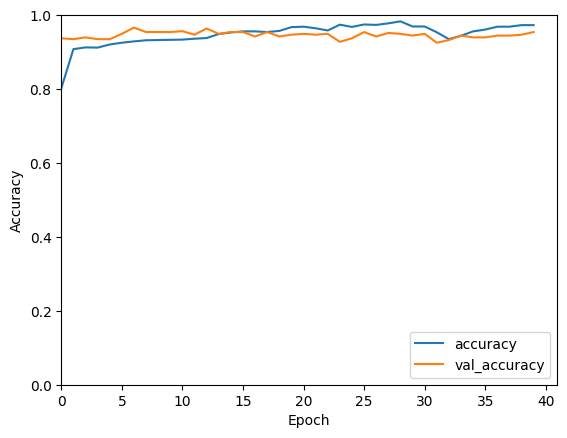

In [12]:
plt.plot(historyCNN_2.history['accuracy'], label='accuracy')
plt.plot(historyCNN_2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.xlim(left=0)
plt.legend(loc='lower right')

In [13]:
resultCNN_2 = modelCNN_2.evaluate(test_dataset, return_dict=True)

print(f'Dokładność modelu {round(resultCNN_2["accuracy"]*100,2)}%')

8/8 [==============================] - 0s 28ms/step - loss: 0.4022 - accuracy: 0.9394
Dokładność modelu 93.94%


Pomimo tej samej dokładności modelu, od samego początku dokładność pozostaje na podobnym, wysokim poziomie i szum jest widocznie mniejszy.

### **Model 3**

Model trzeci jest rozwinięciem modelu pierwszego. Warstwą wejściową jest warstwa konwulcyjna oraz dodana jest warstwa gęsta i warstwa porzucająca pod koniec sekwencji.

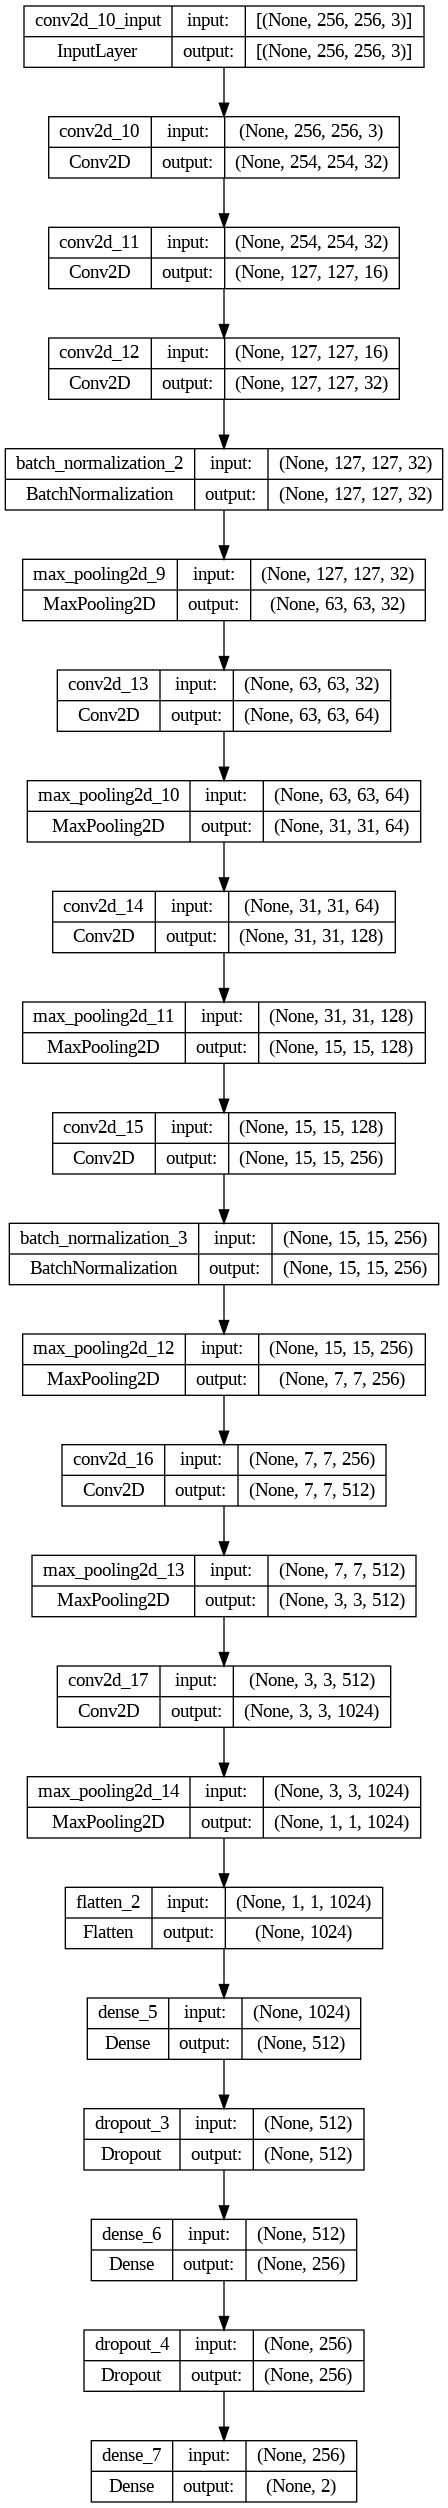

In [14]:
modelCNN_3 = Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
  layers.Conv2D(16, (2,2), strides=2, padding='same', activation="relu"),
  layers.Conv2D(32, (2,2), padding='same', activation="relu"),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Conv2D(64, (2,2), padding='same', activation="relu"),
  layers.MaxPooling2D(2),
  layers.Conv2D(128, (2,2), padding='same', activation="relu"),
  layers.MaxPooling2D(2),
  layers.Conv2D(256, (2,2), padding='same', activation="relu"),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2),
  layers.Conv2D(512, (2,2), padding='same', activation="relu"),
  layers.MaxPooling2D(2),
  layers.Conv2D(1024, (2,2), padding='same', activation="relu"),
  layers.MaxPooling2D(2),
  layers.Flatten(),
  layers.Dense(512, activation="relu"),
  layers.Dropout(0.5),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(2, activation="softmax")
])
plot_model(modelCNN_3, show_shapes=True)

In [15]:
# Kompilacja
modelCNN_3.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])


# Uczenie sieci
historyCNN_3 = modelCNN_3.fit(train_dataset, epochs=50, validation_data=valid_dataset,
                    batch_size=64)

Epoch 1/50
52/52 [==============================] - 7s 49ms/step - loss: 0.7331 - accuracy: 0.7911 - val_loss: 0.4262 - val_accuracy: 0.8434
Epoch 2/50
52/52 [==============================] - 1s 24ms/step - loss: 0.2628 - accuracy: 0.9097 - val_loss: 0.3148 - val_accuracy: 0.9108
Epoch 3/50
52/52 [==============================] - 1s 24ms/step - loss: 0.2243 - accuracy: 0.9169 - val_loss: 0.3376 - val_accuracy: 0.9012
Epoch 4/50
52/52 [==============================] - 1s 24ms/step - loss: 0.2335 - accuracy: 0.9133 - val_loss: 0.3222 - val_accuracy: 0.9084
Epoch 5/50
52/52 [==============================] - 1s 23ms/step - loss: 0.2247 - accuracy: 0.9163 - val_loss: 0.5728 - val_accuracy: 0.5446
Epoch 6/50
52/52 [==============================] - 1s 24ms/step - loss: 0.2309 - accuracy: 0.9037 - val_loss: 0.2336 - val_accuracy: 0.9518
Epoch 7/50
52/52 [==============================] - 1s 23ms/step - loss: 0.2018 - accuracy: 0.9314 - val_loss: 0.2727 - val_accuracy: 0.8867
Epoch 8/50
52

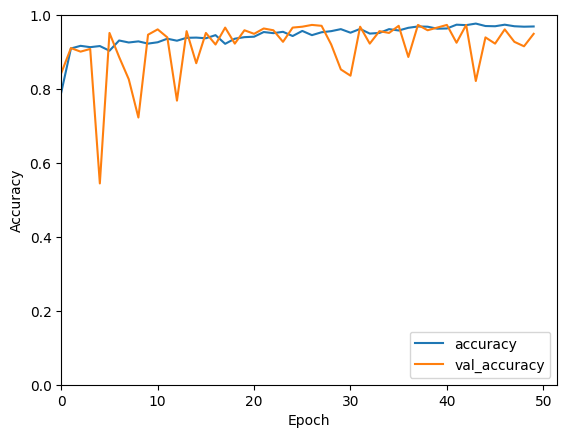

In [16]:
plt.plot(historyCNN_3.history['accuracy'], label='accuracy')
plt.plot(historyCNN_3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.xlim(left=0)
plt.legend(loc='lower right')

In [17]:
resultCNN_3 = modelCNN_3.evaluate(test_dataset, return_dict=True)

print(f'Dokładność modelu {round(resultCNN_3["accuracy"]*100,2)}%')

8/8 [==============================] - 0s 39ms/step - loss: 0.2155 - accuracy: 0.9091
Dokładność modelu 90.91%


Dokładność modelu zmniejszyła się. Pomimo szybszego wzrostu dokładności, ta szybko zaczyna się mocno wahać. Nie jest to z pewnością dobry kierunek optymalizacji.

# **Uczenie Transferowe z zamrożonymi warstwami**

### Metryka categorical_crossentropy

Wczytywana jest funkcja ResNet50, będąca jedną z topowych funkcji uczonych na ImageNet, do uczenia transferowego na modelach z obrazami jako wejściem.

In [18]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


Budowany jest model oraz dodane warstwy GlobalAveragePooling2D (łącząco-spłaszczająca) oraz dwie warstwy gęste.
Następnie tworzony jest model do którego ładowane są wagi z pre-trenowanego modelu.

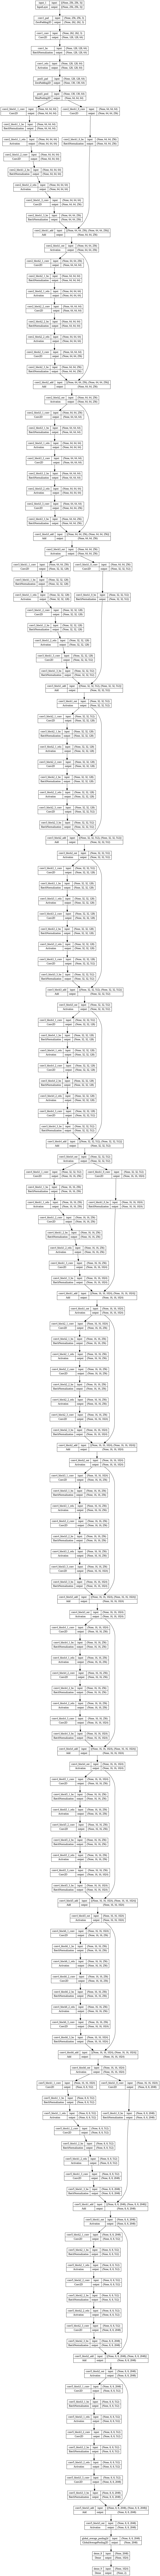

In [19]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Stworzenie końcowego modelu
modelTL = Model(inputs=base_model.input, outputs=predictions)
plot_model(modelTL, show_shapes=True)

Model kompilowany jest znów z optymalizatorem Adam oraz metryką categorical_accuracy. Następnie trening zachodzi na zbiorze treningowym przy 40 epokach.

In [20]:
# Kompilacja modelu
modelTL.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Trening modelu
historyTL = modelTL.fit(train_dataset, validation_data=valid_dataset, epochs=40)

Epoch 1/40
52/52 [==============================] - 9s 88ms/step - loss: 0.5378 - accuracy: 0.8856 - val_loss: 0.1006 - val_accuracy: 0.9639
Epoch 2/40
52/52 [==============================] - 2s 40ms/step - loss: 0.1592 - accuracy: 0.9470 - val_loss: 0.0953 - val_accuracy: 0.9614
Epoch 3/40
52/52 [==============================] - 2s 40ms/step - loss: 0.1167 - accuracy: 0.9609 - val_loss: 0.0868 - val_accuracy: 0.9711
Epoch 4/40
52/52 [==============================] - 2s 39ms/step - loss: 0.1068 - accuracy: 0.9663 - val_loss: 0.0691 - val_accuracy: 0.9759
Epoch 5/40
52/52 [==============================] - 2s 39ms/step - loss: 0.0800 - accuracy: 0.9711 - val_loss: 0.1562 - val_accuracy: 0.9422
Epoch 6/40
52/52 [==============================] - 2s 39ms/step - loss: 0.0814 - accuracy: 0.9735 - val_loss: 0.1122 - val_accuracy: 0.9566
Epoch 7/40
52/52 [==============================] - 2s 39ms/step - loss: 0.0661 - accuracy: 0.9765 - val_loss: 0.0794 - val_accuracy: 0.9687
Epoch 8/40
52

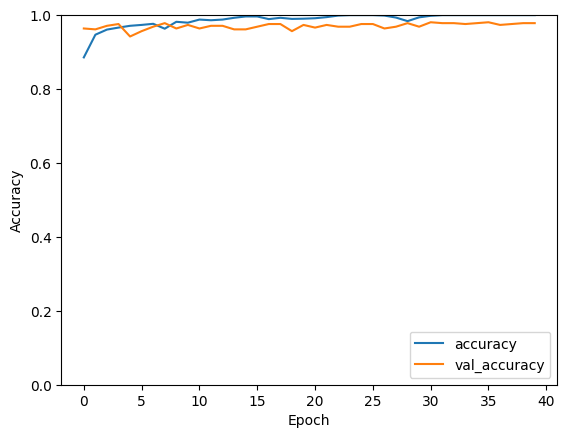

In [21]:
plt.plot(historyTL.history['accuracy'], label='accuracy')
plt.plot(historyTL.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

In [22]:
resultTL = modelTL.evaluate(test_dataset, return_dict=True)

print(f'Dokładność modelu {round(resultTL["accuracy"]*100,2)}%')

8/8 [==============================] - 1s 88ms/step - loss: 0.1548 - accuracy: 0.9784
Dokładność modelu 97.84%


Dokładność modelu jest obecnie najwyższą osiągniętą podczas projektu. Od początku treningu jest ona na wysokim poziomie a szumy są bardzo małe.

### Kompilacja przy użyciu metryki binary_crossentropy

Ten sam model jest kompilowany jednakże przy użyciu metryki binary_accuracy.

In [23]:
# Kompilacja modelu
modelTL_2 = modelTL
modelTL_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=[binary_accuracy])

# Trening modelu
historyTL_2 = modelTL_2.fit(train_dataset, validation_data=valid_dataset, epochs=40)

Epoch 1/40
52/52 [==============================] - 7s 59ms/step - loss: 0.0401 - binary_accuracy: 0.9843 - val_loss: 0.0729 - val_binary_accuracy: 0.9735
Epoch 2/40
52/52 [==============================] - 2s 39ms/step - loss: 0.0102 - binary_accuracy: 0.9982 - val_loss: 0.0769 - val_binary_accuracy: 0.9687
Epoch 3/40
52/52 [==============================] - 2s 39ms/step - loss: 0.0085 - binary_accuracy: 0.9994 - val_loss: 0.0878 - val_binary_accuracy: 0.9711
Epoch 4/40
52/52 [==============================] - 2s 40ms/step - loss: 0.0108 - binary_accuracy: 0.9970 - val_loss: 0.0791 - val_binary_accuracy: 0.9735
Epoch 5/40
52/52 [==============================] - 2s 39ms/step - loss: 0.0099 - binary_accuracy: 0.9982 - val_loss: 0.0869 - val_binary_accuracy: 0.9735
Epoch 6/40
52/52 [==============================] - 2s 39ms/step - loss: 0.0039 - binary_accuracy: 0.9994 - val_loss: 0.0903 - val_binary_accuracy: 0.9663
Epoch 7/40
52/52 [==============================] - 2s 40ms/step - los

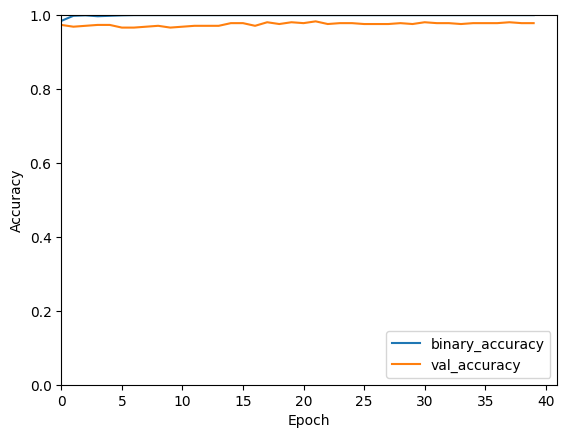

In [24]:
plt.plot(historyTL_2.history['binary_accuracy'], label='binary_accuracy')
plt.plot(historyTL_2.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.xlim(left=0)
plt.legend(loc='lower right')

In [25]:
resultTL_2 = modelTL_2.evaluate(test_dataset, return_dict=True)

print(f'Dokładność modelu {round(resultTL_2["binary_accuracy"]*100,2)}%')

8/8 [==============================] - 0s 27ms/step - loss: 0.1930 - binary_accuracy: 0.9740
Dokładność modelu 97.4%


W tym wypadku wynik ogólny jest odrobinę mniejszy, ale dokładność konsekwentnie zostaje na danym poziomie z praktycznie niewidocznym szumem.

# **Uczenie transferowe z odmrożeniem warstw**

### Odmrożenie małej ilości warstw (~19%)

In [26]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [27]:
for layer in base_model.layers:
    if layer.name in ['conv5_block3_3_conv', 'conv5_block3_2_conv', 'conv5_block3_1_conv']:
        layer.trainable = True

    if layer.trainable:
        print(layer.name)

conv5_block3_1_conv
conv5_block3_2_conv
conv5_block3_3_conv


In [28]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

W tym modelu zostają odmrożone wybrane warstwy konwulcyjne oraz kompilowany i trenowany jest model bazujący na metryce binary_accuracy.

In [29]:
# Kompilacja modelu
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

modelTL_PUF = Model(inputs=base_model.input, outputs=predictions)
modelTL_PUF.compile(optimizer='adam', loss='binary_crossentropy', metrics=[binary_accuracy])

# Trening modelu
historyTL_PUF = modelTL_PUF.fit(train_dataset, validation_data=valid_dataset, epochs=40)

Epoch 1/40
52/52 [==============================] - 10s 78ms/step - loss: 0.5282 - binary_accuracy: 0.8639 - val_loss: 0.0960 - val_binary_accuracy: 0.9711
Epoch 2/40
52/52 [==============================] - 2s 36ms/step - loss: 0.1381 - binary_accuracy: 0.9573 - val_loss: 0.1188 - val_binary_accuracy: 0.9494
Epoch 3/40
52/52 [==============================] - 2s 37ms/step - loss: 0.1042 - binary_accuracy: 0.9693 - val_loss: 0.0901 - val_binary_accuracy: 0.9639
Epoch 4/40
52/52 [==============================] - 2s 36ms/step - loss: 0.1079 - binary_accuracy: 0.9705 - val_loss: 0.0751 - val_binary_accuracy: 0.9759
Epoch 5/40
52/52 [==============================] - 2s 37ms/step - loss: 0.1052 - binary_accuracy: 0.9717 - val_loss: 0.1818 - val_binary_accuracy: 0.9542
Epoch 6/40
52/52 [==============================] - 2s 36ms/step - loss: 0.0908 - binary_accuracy: 0.9753 - val_loss: 0.0580 - val_binary_accuracy: 0.9759
Epoch 7/40
52/52 [==============================] - 2s 37ms/step - lo

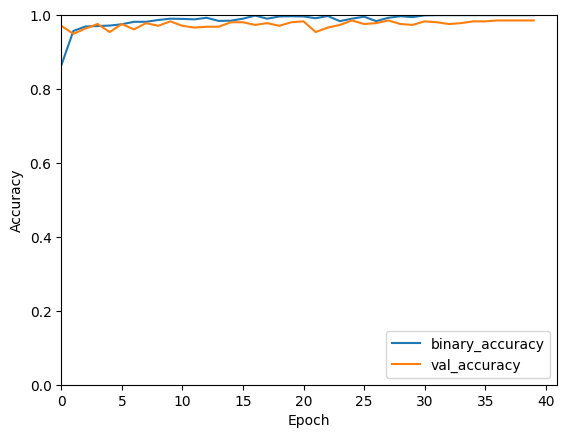

In [30]:
plt.plot(historyTL_PUF.history['binary_accuracy'], label='binary_accuracy')
plt.plot(historyTL_PUF.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.xlim(left=0)
plt.legend(loc='lower right')

In [31]:
resultTL_PUF = modelTL_PUF.evaluate(test_dataset, return_dict=True)

print(f'Dokładność modelu {round(resultTL_PUF["binary_accuracy"]*100,2)}%')

8/8 [==============================] - 0s 28ms/step - loss: 0.6474 - binary_accuracy: 0.9827
Dokładność modelu 98.27%


Model ten cechuje się odrobinę mniejszą dokładnością, jednakże widoczny jest również jeden moment drobnego przeuczenia. Wydaje się natomiast że po zredukowaniu go, dokładność byłaby większa niż w modelu z zamrożonymi warstwami.

### Odmrożenie większej ilości warstw (~63,5%)

W tym przyadpku odmrożone zostają wszystkie warstwy z kategorii conv5.

In [32]:
for layer in base_model.layers:
    if layer.name.startswith('conv5'):
        layer.trainable = True

    if layer.trainable:
        print(layer.name)

conv5_block1_1_conv
conv5_block1_1_bn
conv5_block1_1_relu
conv5_block1_2_conv
conv5_block1_2_bn
conv5_block1_2_relu
conv5_block1_0_conv
conv5_block1_3_conv
conv5_block1_0_bn
conv5_block1_3_bn
conv5_block1_add
conv5_block1_out
conv5_block2_1_conv
conv5_block2_1_bn
conv5_block2_1_relu
conv5_block2_2_conv
conv5_block2_2_bn
conv5_block2_2_relu
conv5_block2_3_conv
conv5_block2_3_bn
conv5_block2_add
conv5_block2_out
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out


In [33]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [34]:
# Kompilacja modelu
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

modelTL_PUF2 = Model(inputs=base_model.input, outputs=predictions)
modelTL_PUF2.compile(optimizer='adam', loss='binary_crossentropy', metrics=[binary_accuracy])

# Trening modelu
historyTL_PUF2 = modelTL_PUF2.fit(train_dataset, validation_data=valid_dataset, epochs=40)

Epoch 1/40
52/52 [==============================] - 11s 63ms/step - loss: 0.2210 - binary_accuracy: 0.9326 - val_loss: 14.4032 - val_binary_accuracy: 0.6337
Epoch 2/40
52/52 [==============================] - 2s 42ms/step - loss: 0.0692 - binary_accuracy: 0.9765 - val_loss: 0.4279 - val_binary_accuracy: 0.9398
Epoch 3/40
52/52 [==============================] - 2s 41ms/step - loss: 0.0384 - binary_accuracy: 0.9868 - val_loss: 0.1145 - val_binary_accuracy: 0.9735
Epoch 4/40
52/52 [==============================] - 2s 42ms/step - loss: 0.0438 - binary_accuracy: 0.9849 - val_loss: 0.0934 - val_binary_accuracy: 0.9783
Epoch 5/40
52/52 [==============================] - 2s 42ms/step - loss: 0.0415 - binary_accuracy: 0.9825 - val_loss: 0.1388 - val_binary_accuracy: 0.9759
Epoch 6/40
52/52 [==============================] - 2s 41ms/step - loss: 0.0167 - binary_accuracy: 0.9922 - val_loss: 0.1314 - val_binary_accuracy: 0.9783
Epoch 7/40
52/52 [==============================] - 2s 41ms/step - l

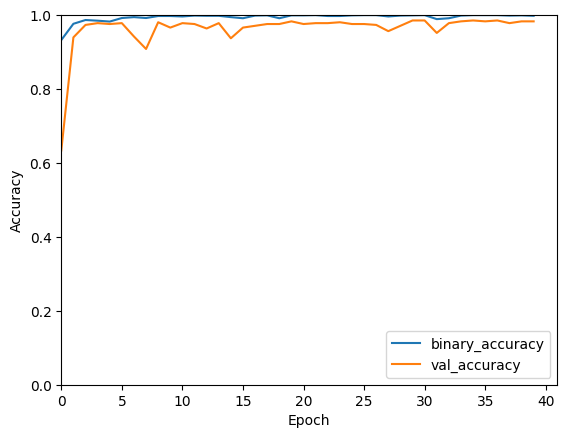

In [35]:
plt.plot(historyTL_PUF2.history['binary_accuracy'], label='binary_accuracy')
plt.plot(historyTL_PUF2.history['val_binary_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.xlim(left=0)
plt.legend(loc='lower right')

In [36]:
resultTL_PUF_2 = modelTL_PUF2.evaluate(test_dataset, return_dict=True)

print(f'Dokładność modelu {round(resultTL_PUF_2["binary_accuracy"]*100,2)}%')

8/8 [==============================] - 0s 28ms/step - loss: 0.1996 - binary_accuracy: 0.9784
Dokładność modelu 97.84%


Zwiększenie ilości odmrożonych warstw wpłynęło lepiej na wynik dokładności, jednakże widocznym jest że pierwotna dokładność jest na relatywnie małym poziomie oraz widać wiele momentów przeuczenia. Zapobiegnięcie im z pewnością zwiększyłoby dokładność być może do największego poziomu w obecnych badaniach.

# **Wyniki**

Przygotowanie funkcji prognozującej

In [46]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score, precision_score, recall_score

def get_predictions(model, dataset):
    predictions = []
    labels = []
    for images, labels_batch in dataset:
        predictions_batch = model.predict(images)
        predictions.extend(np.argmax(predictions_batch, axis=1))
        labels.extend(np.argmax(labels_batch, axis=1))
    return np.array(predictions), np.array(labels)


## Wyniki dla najlepszego modelu CNN

In [47]:
predictions, labels = get_predictions(modelCNN_2, test_dataset)

1/1 [==============================] - 0s 23ms/step


In [48]:
f1score = f1_score(labels, predictions, average='weighted')
print(f"Wynik F1: {f1score}")

Wynik F1: 0.9393939393939394


In [49]:
conf_matrix = confusion_matrix(labels, predictions)
print("Macierz konfuzji:")
print(conf_matrix)

Macierz konfuzji:
[[106   7]
 [  7 111]]


In [50]:
bac = balanced_accuracy_score(labels, predictions)
print(f"Zbalansowana dokładność (BAC): {bac}")

Zbalansowana dokładność (BAC): 0.9393655317234139


## Wyniki dla najlepszego modelu TL

In [51]:
predictions, labels = get_predictions(modelTL_2, test_dataset)

1/1 [==============================] - 0s 27ms/step


In [52]:
f1score = f1_score(labels, predictions, average='weighted')
print(f"Wynik F1: {f1score}")

Wynik F1: 0.9783525429095049


In [53]:
conf_matrix = confusion_matrix(labels, predictions)
print("Macierz konfuzji:")
print(conf_matrix)

Macierz konfuzji:
[[110   3]
 [  2 116]]


In [54]:
bac = balanced_accuracy_score(labels, predictions)
print(f"Zbalansowana dokładność (BAC): {bac}")

Zbalansowana dokładność (BAC): 0.9782510874456277


## Wyniki dla najlepszego modelu TL_PUF (Partial UnFreeze)

In [55]:
predictions, labels = get_predictions(modelTL_PUF, test_dataset)

1/1 [==============================] - 1s 962ms/step


In [56]:
f1score = f1_score(labels, predictions, average='weighted')
print(f"Wynik F1: {f1score}")

Wynik F1: 0.3213782341689318


In [57]:
conf_matrix = confusion_matrix(labels, predictions)
print("Macierz konfuzji:")
print(conf_matrix)

Macierz konfuzji:
[[113   0]
 [118   0]]


In [58]:
bac = balanced_accuracy_score(labels, predictions)
print(f"Zbalansowana dokładność (BAC): {bac}")

Zbalansowana dokładność (BAC): 0.5


## Porównanie wyników

Po weryfikacji najlepszych modeli w swoich architekturach, na prowadzenie wychodzą model sieci konwulcyjnych oraz model uczenia transferowego.

Wyniki F1-score oraz zbalansowanej dokłądności jednoznacznie wskazują na model uczenia transferowego, dodatkowo macierz konfuzji pokazuje że posiada on najmniej klas fałszywie dodatnich i fałszywie ujemnych.

Model sieci konwulcyjnych natomiast choć prezentuje mniejsze wartości w każdej z metryk, to osiągają one jednak wciąż wysoki poziom z macierzą konfuzji nieznacznie gorszą od modelu TL.

Model z częściowym odmrożeniem warstw jednak nie zdał testu i wypada naprawdę blado w porównaniu z innymi modelami. F1 oraz BAC są na bardzo słabym poziomie a w macierzy konfuzji nad prawdziwie dodatnimi klasami triumfują fałszywie dodatnie.

# **Podsumowanie**

Po przeprowadzeniu badania na trzech różnych architekturach sieci neuronowych można wysnuć następujące wnioski:

*   Choć wyniki sugerują że model uczenia transferowego jest najlepszym modelem, nie jest on tak elastyczny na modyfikacje, a z pewnością nie na odmrażanie warstw. Sieci konwulcyjne natomiast posiadają ogromną zaletę wprowadzania wielu nawet małych zmian które przy długofalowym badaniu mogą zaowocować w jeszcze bardziej satysfakcjonujący wynik, ryzykując nawet stwierdzenie że lepszy niż w przypadku uczenia transferowego.
*   Pomimo porównywania architektur sieci konwulcyjnych i uczenia transferowego, warto zauważyć że dokładność i wyniki metryk już znajdują się na bardzo wysokim poziomie, który spokojnie pozwalałby na skuteczne działanie algorytmu w praktyce.
*   Następnym krokiem wydawałaby się próba pracy nad modelami budowanymi w sieci konwulcyjnej i jużnawet na podstawie obecnych modeli wyciągnięcie wniosków, jakie zmiany pozytywnie wpływają na wyniki



